In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data_path = "/content/gdrive/My Drive/Data/"
model_path = "/content/gdrive/My Drive/Models/"

In [3]:
pip install transformers

     |████████████████████████████████| 1.4MB 12.9MB/s 
     |████████████████████████████████| 890kB 57.0MB/s 
     |████████████████████████████████| 2.9MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c909e3d7c4eecb91f7762cba08b765d766dc700610ee0d99091c992231add31f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_file = open(data_path + 'QC_train.txt')
test_file = open(data_path + 'QC_test.txt')

In [7]:
def get_df(inp_file):
  return pd.DataFrame(inp_file.readlines(), columns=['Question'])

In [8]:
train_data = get_df(train_file)
test_data = get_df(test_file)

In [25]:
train_data.head()

,Question
0,DESC:manner How did serfdom develop in and the...
1,ENTY:cremat What films featured the character ...
2,DESC:manner How can I find a list of celebriti...
3,ENTY:animal What fowl grabs the spotlight afte...
4,ABBR:exp What is the full form of .com ?\n


In [9]:
def improve_df(df):
  df['Type'] = df['Question'].apply(lambda s: s.split(' ', 1)[0])
  df['Question'] = df['Question'].apply(lambda s: s.split(' ', 1)[1])
  df['TypeSimple'] = df['Type'].apply(lambda s: s.split(':')[0])
  df['TypeExtended'] = df['Type'].apply(lambda s: s.split(':')[1])
  return df

In [10]:
train_data = improve_df(train_data)
test_data = improve_df(test_data)

In [28]:
train_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How did serfdom develop in and then leave Russ...,DESC:manner,DESC,manner
1,What films featured the character Popeye Doyle...,ENTY:cremat,ENTY,cremat
2,How can I find a list of celebrities ' real na...,DESC:manner,DESC,manner
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,ENTY,animal
4,What is the full form of .com ?\n,ABBR:exp,ABBR,exp


In [29]:
test_data.describe()

,Question,Type,TypeSimple,TypeExtended
count,500,500,500,500
unique,500,42,6,39
top,What is the speed of light ?\n,DESC:def,DESC,def
freq,1,123,138,123


In [30]:
test_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How far is it from Denver to Aspen ?\n,NUM:dist,NUM,dist
1,"What county is Modesto , California in ?\n",LOC:city,LOC,city
2,Who was Galileo ?\n,HUM:desc,HUM,desc
3,What is an atom ?\n,DESC:def,DESC,def
4,When did Hawaii become a state ?\n,NUM:date,NUM,date


In [31]:
train_data.append(test_data).describe()

,Question,Type,TypeSimple,TypeExtended
count,5952,5952,5952,5952
unique,5871,50,6,47
top,What seven digits follow the area code in the ...,HUM:ind,ENTY,ind
freq,3,1017,1344,1017


In [11]:
train_data['TypeSimple'].unique()

array(['DESC', 'ENTY', 'ABBR', 'HUM', 'NUM', 'LOC'], dtype=object)

In [39]:
train_data['TypeExtended'].unique()

array(['manner', 'cremat', 'animal', 'exp', 'ind', 'gr', 'title', 'def',
       'date', 'reason', 'event', 'state', 'desc', 'count', 'other',
       'letter', 'religion', 'food', 'country', 'color', 'termeq', 'city',
       'body', 'dismed', 'mount', 'money', 'product', 'period',
       'substance', 'sport', 'plant', 'techmeth', 'volsize', 'instru',
       'abb', 'speed', 'word', 'lang', 'perc', 'code', 'dist', 'temp',
       'symbol', 'ord', 'veh', 'weight', 'currency'], dtype=object)

In [36]:
train_data['Type'].unique()

array(['DESC:manner', 'ENTY:cremat', 'ENTY:animal', 'ABBR:exp', 'HUM:ind',
       'HUM:gr', 'HUM:title', 'DESC:def', 'NUM:date', 'DESC:reason',
       'ENTY:event', 'LOC:state', 'DESC:desc', 'NUM:count', 'ENTY:other',
       'ENTY:letter', 'LOC:other', 'ENTY:religion', 'ENTY:food',
       'LOC:country', 'ENTY:color', 'ENTY:termeq', 'LOC:city',
       'ENTY:body', 'ENTY:dismed', 'LOC:mount', 'NUM:money',
       'ENTY:product', 'NUM:period', 'ENTY:substance', 'ENTY:sport',
       'ENTY:plant', 'ENTY:techmeth', 'NUM:volsize', 'HUM:desc',
       'ENTY:instru', 'ABBR:abb', 'NUM:other', 'NUM:speed', 'ENTY:word',
       'ENTY:lang', 'NUM:perc', 'NUM:code', 'NUM:dist', 'NUM:temp',
       'ENTY:symbol', 'NUM:ord', 'ENTY:veh', 'NUM:weight',
       'ENTY:currency'], dtype=object)

In [11]:
TARGET_NAMES = train_data['TypeSimple'].unique().tolist()

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def encode_tag(train_data, test_data, tag):
  l_enc = LabelEncoder()
  l_enc.fit(pd.Series(train_data[tag].tolist() + test_data[tag].tolist()).values)
  return l_enc.transform(train_data[tag].values), l_enc.transform(test_data[tag].values)

In [14]:
tag = 'Type'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)
tag = 'TypeSimple'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)
tag = 'TypeExtended'
train_data[tag], test_data[tag] = encode_tag(train_data, test_data, tag)

In [19]:
train_data.head()

,Question,Type,TypeSimple,TypeExtended
0,How did serfdom develop in and then leave Russ...,4,1,23
1,What films featured the character Popeye Doyle...,9,2,8
2,How can I find a list of celebrities ' real na...,4,1,23
3,What fowl grabs the spotlight after the Chines...,6,2,1
4,What is the full form of .com ?\n,1,0,16


In [16]:
train_data.columns

Index(['Question', 'Type', 'TypeSimple', 'TypeExtended'], dtype='object')

In [17]:
train_data['TypeSimple'].unique()

array([1, 2, 0, 3, 5, 4])

In [15]:
SRC_COL = 'Question'
TRG_COL = 'TypeSimple'

In [16]:
TARGETS = train_data[TRG_COL].unique().tolist()
print(TARGETS)

[1, 2, 0, 3, 5, 4]


In [17]:
TARGET_DICT = dict()
for i in range(len(TARGET_NAMES)):
  TARGET_DICT[TARGETS[i]] = TARGET_NAMES[i]

In [18]:
TARGET_DICT

{0: 'ABBR', 1: 'DESC', 2: 'ENTY', 3: 'HUM', 4: 'LOC', 5: 'NUM'}

In [19]:
BERT_MODEL_NAME = 'bert-base-cased' 

In [20]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [24]:
token_lengths = []
for sent in train_data[SRC_COL]:
  tokens = tokenizer.encode(sent, max_length=tokenizer.max_model_input_sizes[BERT_MODEL_NAME])
  token_lengths.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [26]:
rcParams['figure.figsize'] = 8, 6

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

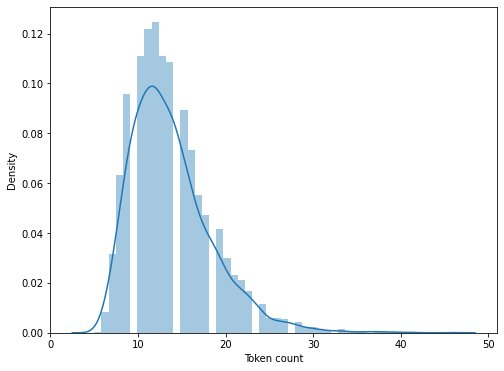

In [27]:
sns.distplot(token_lengths)
plt.xlim([0, tokenizer.max_model_input_sizes[BERT_MODEL_NAME] // 10])
plt.xlabel('Token count')

In [21]:
MAX_LEN = 32

In [ ]:
class QuestionsDataset(Dataset):
  def __init__(self, src_list, trg_list, tokenizer, MAX_LEN):
    self.src_list = src_list
    self.trg_list = trg_list
    self.tokenizer = tokenizer
    self.MAX_LEN = MAX_LEN
  
  def __len__(self):
    return len(self.src_list)
  
  def __getitem__(self, item):
    src = str(self.src_list[item])
    trg = self.trg_list[item]
    encoder = tokenizer.encode_plus(
      src, add_special_tokens=True,
      max_length=self.MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {'src': src, 'input_ids': encoder['input_ids'].flatten(), 'attention_mask': encoder['attention_mask'].flatten(), 'trg': torch.tensor(trg, dtype=torch.long)}

In [ ]:
def get_loader(df, tokenizer, MAX_LEN, BATCH_SIZE):
  data = QuestionsDataset(src_list=df[SRC_COL].to_numpy(), trg_list=df[TRG_COL].to_numpy(), tokenizer=tokenizer, MAX_LEN=MAX_LEN)
  loader = DataLoader(data, batch_size=BATCH_SIZE)
  return loader

In [ ]:
BATCH_SIZE = 32

train_loader = get_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = get_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['trg'].shape)

torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME)

In [ ]:
res = bert(input_ids=data['input_ids'], attention_mask=data['attention_mask'])

In [ ]:
res[0].shape

torch.Size([32, 32, 768])

In [ ]:
res[1].shape

torch.Size([32, 768])

In [ ]:
res1 = nn.Linear(bert.config.hidden_size, 256 * 2)(res[1])

In [ ]:
res1.shape

torch.Size([32, 512])

In [ ]:
torch.cat((res1, res1), dim=1).reshape(4, res1.size(0), res1.size(1) // 2).shape

torch.Size([4, 32, 256])

In [ ]:
h, hid = nn.GRU(bert.config.hidden_size, 256, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)(res[0], torch.cat((res1, res1), dim=1).reshape(4, 32, 256))

In [ ]:
h.shape

torch.Size([32, 32, 512])

In [ ]:
hid.shape

torch.Size([4, 32, 256])

In [ ]:
torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1).shape

torch.Size([32, 512])

In [22]:
class Classifier(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(Classifier, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[1]
    emb = self.drop(emb)
    out = self.emb2out(emb)
    return out

In [25]:
classifier = Classifier(bert, 0.3, len(TARGETS))
classifier = classifier.to(device)

In [ ]:
EPOCHS = 5
optim = AdamW(classifier.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV2(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(ClassifierV2, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid = nn.Linear(self.inp2emb.config.hidden_size, self.inp2emb.config.hidden_size)
    self.hid2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[1]
    emb = self.drop(emb)
    hid = self.emb2hid(emb)
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV2 = ClassifierV2(bert, 0.3, len(TARGETS))
classifierV2 = classifierV2.to(device)

In [ ]:
EPOCHS = 5
optim = AdamW(classifierV2.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV3(nn.Module):
  def __init__(self, bert, p, num_tags, hid_dim, num_lay):
    super(ClassifierV3, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid = nn.GRU(self.inp2emb.config.hidden_size, hid_dim, num_layers=num_lay, bidirectional=True, batch_first=True, dropout=p)
    self.hid2out = nn.Linear(hid_dim * 2, num_tags)

  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[0]
    h, hid = self.emb2hid(emb)
    hid = self.drop(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1))
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV3 = ClassifierV3(bert, 0.3, len(TARGETS), 256, 2)
classifierV3 = classifierV3.to(device)

In [ ]:
sum(p.numel() for p in classifierV3.parameters() if p.requires_grad)

111072006

In [ ]:
for name, param in classifierV3.named_parameters():
  if name.startswith('inp2emb'):
    param.requires_grad = False

In [ ]:
sum(p.numel() for p in classifierV3.parameters() if p.requires_grad)

2761734

In [ ]:
EPOCHS = 20
optim = AdamW(classifierV3.parameters(), lr=5e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
class ClassifierV4(nn.Module):
  def __init__(self, bert, p, num_tags, hid_dim, num_lay):
    super(ClassifierV4, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid0 = nn.Linear(self.inp2emb.config.hidden_size, hid_dim * 2)
    self.emb2hid = nn.GRU(self.inp2emb.config.hidden_size, hid_dim, num_layers=num_lay, bidirectional=True, batch_first=True, dropout=p)
    self.hid2out = nn.Linear(hid_dim * 2, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)
    hid0 = self.emb2hid0(emb[1])
    hid0 = torch.cat((hid0, hid0), dim=1).reshape(4, hid0.size(0), hid0.size(1) // 2)
    h, hid = self.emb2hid(emb[0], hid0)
    hid = self.drop(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1))
    out = self.hid2out(hid)
    return out

In [ ]:
classifierV4 = ClassifierV4(bert, 0.3, len(TARGETS), 128, 2)
classifierV4 = classifierV4.to(device)

In [ ]:
EPOCHS = 10
optim = AdamW(classifierV4.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, loader, crit, optim, device, num_ex):
  model = model.train()
  losses = []
  correct = 0

  for data in loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    trg = data['trg'].to(device)

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    _, pred = torch.max(out, dim=1)
    loss = crit(out, trg)
    correct += torch.sum(pred == trg)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    optim.zero_grad()
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
def eval(model, loader, crit, device, num_ex):
  model = model.eval()
  losses = []
  correct = 0

  with torch.no_grad():
    for data in loader:
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      trg = data['trg'].to(device)

      out = model(input_ids=input_ids, attention_mask=attention_mask)
      _, pred = torch.max(out, dim=1)
      loss = crit(out, trg)
      correct += torch.sum(pred == trg)
      losses.append(loss.item())
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
name = 'QC_StandardSimple'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifier, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifier, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifier.state_dict(), model_path + name + '.pt')

Epoch  1 / 5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.8409565178274411  | Train acc =  tensor(0.7043, device='cuda:0', dtype=torch.float64)
Val loss =  0.1858578915707767  | Val acc =  tensor(0.9600, device='cuda:0', dtype=torch.float64)
Epoch  2 / 5
----------
Train loss =  0.18142185625974197  | Train acc =  tensor(0.9481, device='cuda:0', dtype=torch.float64)
Val loss =  0.1711366816307418  | Val acc =  tensor(0.9580, device='cuda:0', dtype=torch.float64)
Epoch  3 / 5
----------
Train loss =  0.0924385528731002  | Train acc =  tensor(0.9754, device='cuda:0', dtype=torch.float64)
Val loss =  0.2017734306573402  | Val acc =  tensor(0.9660, device='cuda:0', dtype=torch.float64)
Epoch  4 / 5
----------
Train loss =  0.04715117942187826  | Train acc =  tensor(0.9890, device='cuda:0', dtype=torch.float64)
Val loss =  0.21390219436580082  | Val acc =  tensor(0.9660, device='cuda:0', dtype=torch.float64)
Epoch  5 / 5
----------
Train loss =  0.029092863585380564  | Train acc =  tensor(0.9927, device='cuda:0', dtype=torch.float6

In [26]:
classifier.load_state_dict(torch.load(model_path + 'QC_StandardSimple.pt'))

<All keys matched successfully>

In [27]:
def classify(model, sent):
  encoded = tokenizer.encode_plus(sent, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  out = model(input_ids, attention_mask)
  _, pred = torch.max(out, dim=1)

  return TARGET_DICT[pred.item()]

In [34]:
classify(classifier, 'What does NLP stand for ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'ABBR'

In [35]:
classify(classifier, 'What is the training strategy for recurrent neural networks ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'ENTY'

In [36]:
classify(classifier, 'What is the training strategy for athletes ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'DESC'

In [37]:
classify(classifier, 'What is the name of this monitor model ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'ENTY'

In [38]:
classify(classifier, 'What is the name of a company that produces this monitor model ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'HUM'

In [39]:
classify(classifier, 'What is the highest point in the world ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'LOC'

In [40]:
classify(classifier, 'What is the distance to the Moon ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'NUM'

In [41]:
classify(classifier, 'How far is the Moon ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'NUM'

In [42]:
classify(classifier, 'How fast is a sports car ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'NUM'

In [43]:
classify(classifier, 'How expensive is a sports car ?')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'NUM'

In [28]:
classify(classifier, 'How to reveal the truth ?')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'DESC'

In [ ]:
name = 'QC_V2Simple'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV2, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV2, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV2.state_dict(), model_path + name + '.pt')

Epoch  1 / 5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.8775562671018623  | Train acc =  tensor(0.6799, device='cuda:0', dtype=torch.float64)
Val loss =  0.19073277479037642  | Val acc =  tensor(0.9580, device='cuda:0', dtype=torch.float64)
Epoch  2 / 5
----------
Train loss =  0.2133379129703805  | Train acc =  tensor(0.9457, device='cuda:0', dtype=torch.float64)
Val loss =  0.1407251110067591  | Val acc =  tensor(0.9720, device='cuda:0', dtype=torch.float64)
Epoch  3 / 5
----------
Train loss =  0.11074302133379711  | Train acc =  tensor(0.9738, device='cuda:0', dtype=torch.float64)
Val loss =  0.15037238411605358  | Val acc =  tensor(0.9680, device='cuda:0', dtype=torch.float64)
Epoch  4 / 5
----------
Train loss =  0.05834613110439863  | Train acc =  tensor(0.9855, device='cuda:0', dtype=torch.float64)
Val loss =  0.10013237154635135  | Val acc =  tensor(0.9820, device='cuda:0', dtype=torch.float64)
Epoch  5 / 5
----------
Train loss =  0.04128163271619018  | Train acc =  tensor(0.9912, device='cuda:0', dtype=torch.float

In [ ]:
name = 'QC_V3Simple'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV3, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV3, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV3.state_dict(), model_path + name + '.pt')

Epoch  1 / 20
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  1.4316574411782605  | Train acc =  tensor(0.4820, device='cuda:0', dtype=torch.float64)
Val loss =  0.9508375227451324  | Val acc =  tensor(0.7360, device='cuda:0', dtype=torch.float64)
Epoch  2 / 20
----------
Train loss =  0.8086324316716333  | Train acc =  tensor(0.7386, device='cuda:0', dtype=torch.float64)
Val loss =  0.4772086329758167  | Val acc =  tensor(0.8480, device='cuda:0', dtype=torch.float64)
Epoch  3 / 20
----------
Train loss =  0.5573127893676535  | Train acc =  tensor(0.8036, device='cuda:0', dtype=torch.float64)
Val loss =  0.3741667279973626  | Val acc =  tensor(0.8860, device='cuda:0', dtype=torch.float64)
Epoch  4 / 20
----------
Train loss =  0.46355545172217294  | Train acc =  tensor(0.8375, device='cuda:0', dtype=torch.float64)
Val loss =  0.3264863253571093  | Val acc =  tensor(0.9000, device='cuda:0', dtype=torch.float64)
Epoch  5 / 20
----------
Train loss =  0.4123199941993457  | Train acc =  tensor(0.8501, device='cuda:0', dtype=torch.float6

Epoch  1 / 20
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.16269637101564055  | Train acc =  tensor(0.9420, device='cuda:0', dtype=torch.float64)
Val loss =  0.16963850031606853  | Val acc =  tensor(0.9580, device='cuda:0', dtype=torch.float64)
Epoch  2 / 20
----------
Train loss =  0.1495719695387528  | Train acc =  tensor(0.9486, device='cuda:0', dtype=torch.float64)
Val loss =  0.17750404123216867  | Val acc =  tensor(0.9540, device='cuda:0', dtype=torch.float64)
Epoch  3 / 20
----------
Train loss =  0.1425380244039609  | Train acc =  tensor(0.9503, device='cuda:0', dtype=torch.float64)
Val loss =  0.18898114070179872  | Val acc =  tensor(0.9440, device='cuda:0', dtype=torch.float64)
Epoch  4 / 20
----------
Train loss =  0.13377385173940606  | Train acc =  tensor(0.9532, device='cuda:0', dtype=torch.float64)
Val loss =  0.16423410893185064  | Val acc =  tensor(0.9560, device='cuda:0', dtype=torch.float64)
Epoch  5 / 20
----------
Train loss =  0.13067547864776258  | Train acc =  tensor(0.9534, device='cuda:0', dtype=torch.

Epoch  1 / 20
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.06919176804449148  | Train acc =  tensor(0.9743, device='cuda:0', dtype=torch.float64)
Val loss =  0.2087714962544851  | Val acc =  tensor(0.9480, device='cuda:0', dtype=torch.float64)
Epoch  2 / 20
----------
Train loss =  0.06899278540006289  | Train acc =  tensor(0.9767, device='cuda:0', dtype=torch.float64)
Val loss =  0.24543361250835005  | Val acc =  tensor(0.9480, device='cuda:0', dtype=torch.float64)
Epoch  3 / 20
----------
Train loss =  0.07084797564328904  | Train acc =  tensor(0.9729, device='cuda:0', dtype=torch.float64)
Val loss =  0.27790964976884425  | Val acc =  tensor(0.9460, device='cuda:0', dtype=torch.float64)
Epoch  4 / 20
----------
Train loss =  0.06650793806606174  | Train acc =  tensor(0.9773, device='cuda:0', dtype=torch.float64)
Val loss =  0.19686450634617358  | Val acc =  tensor(0.9580, device='cuda:0', dtype=torch.float64)
Epoch  5 / 20
----------
Train loss =  0.06210700165867065  | Train acc =  tensor(0.9778, device='cuda:0', dtype=torch

In [ ]:
name = 'QC_V4Simple'
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(classifierV4, train_loader, crit, optim, device, len(train_data))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(classifierV4, test_loader, crit, device, len(test_data))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(classifierV4.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.720185755899078  | Train acc =  tensor(0.7671, device='cuda:0', dtype=torch.float64)
Val loss =  0.16436817264184356  | Val acc =  tensor(0.9640, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  0.18504050008037634  | Train acc =  tensor(0.9536, device='cuda:0', dtype=torch.float64)
Val loss =  0.14544656313955784  | Val acc =  tensor(0.9700, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.08617780166433046  | Train acc =  tensor(0.9809, device='cuda:0', dtype=torch.float64)
Val loss =  0.13785107189323753  | Val acc =  tensor(0.9720, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.04815776572067138  | Train acc =  tensor(0.9903, device='cuda:0', dtype=torch.float64)
Val loss =  0.19400997803313658  | Val acc =  tensor(0.9680, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.028891878581077557  | Train acc =  tensor(0.9945, device='cuda:0', dtype=torch